# VTOL Take-off Failure Options

Looking at some of the options in terms of engine failure(s) during a vertical take-off of an aircraft like the [Pegasus Vertical Business Jet (VBJ)](https://pegasusua.com/pegasus-vertical-business-jet/).

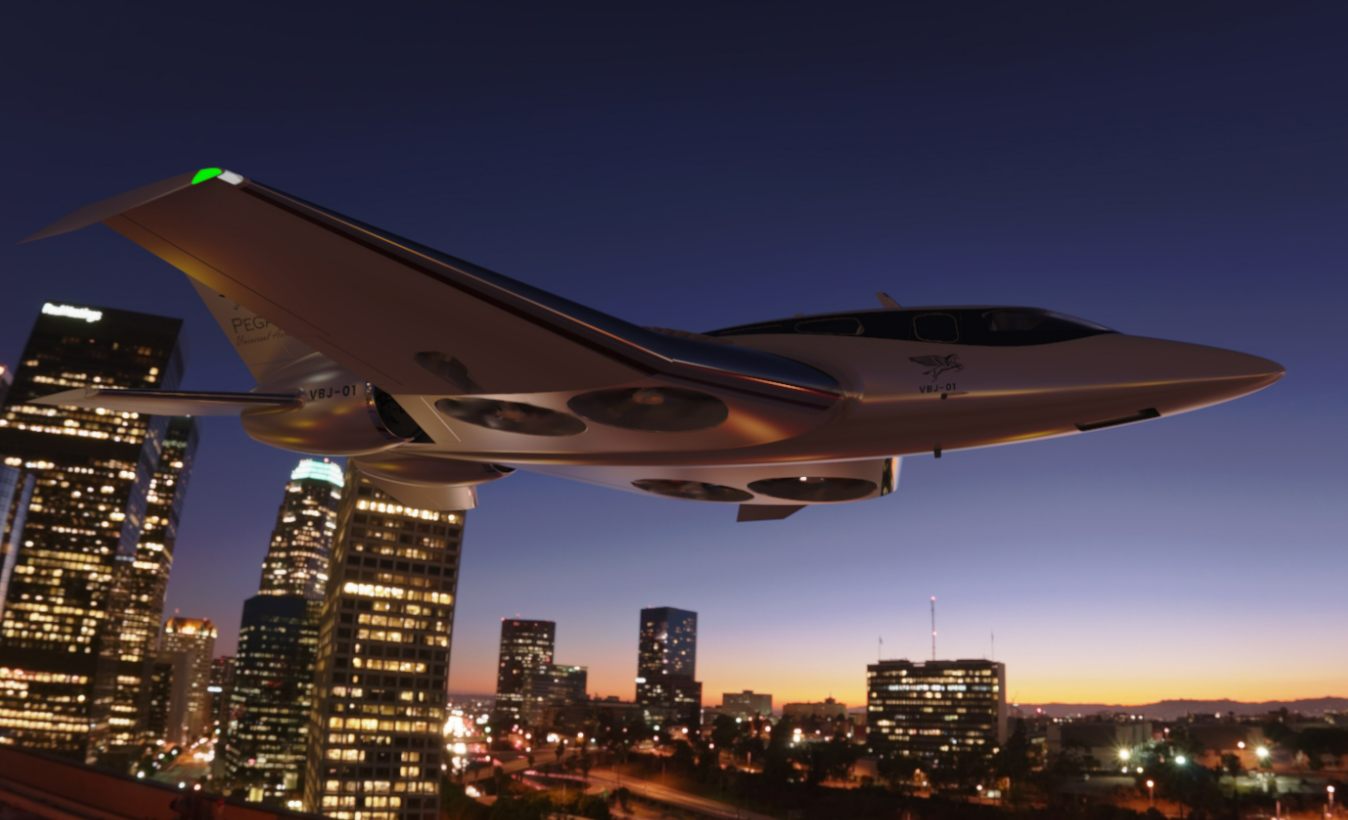

## Vertical Descent

Initially assume a purely vertical descent after a partial or complete engine failure to determine what the maximum height 
is that the aircraft can descend from and land sucessfully based on the landing gear's rating.

Basic kinematics.

$  s = v_0 + \frac{1}{2}at^2 \tag{1} $

$ v = v_0 + at  \tag{2} $

Assuming $v_0$ is 0 then we can solve for the final velocity when hitting the ground from a starting height of $s$ and ignoring any drag.

$  t = \sqrt{\frac{2s}{a}} \tag{3} $

$ v = a \sqrt{\frac{2s}{a}}  \tag{4} $

Or assuming a maximum $v$ based on gear strength and a known acceleration $a$ we can solve for $s$.

$ s = \frac{v^2}{2a} \tag{5} $

### Total Engine Failure

Now assuming a maximum vertical speed of say 1,000fpm (5.1m/s) in terms of what the landing gear are rated to and assuming a total engine failure, i.e. $ a = g $.

$  s = \frac{5.1^2}{2 \, \times \, 9.81} = 1.3m$

So the aircraft can only handle a total engine failure from 1.3m?

### Partial Engine Failure

For example 1 of the 2 engines failing. Let's assume the thrust to weight ratio with both engines at full thrust is 1.2, so 
a thrust to weight ratio of 0.6 with a single engine failure. So $a = (1 - 0.6)g$ in this case.

$ s = \frac{5.1^2}{2 \, \times \, (1 \,  - \, 0.6) \, \times \, 9.81} = 3.3m $

Calculate and plot the safe height for partial engine failure versus the thrust to weight ratio available after the partial engine failure.

<IPython.core.display.Javascript object>


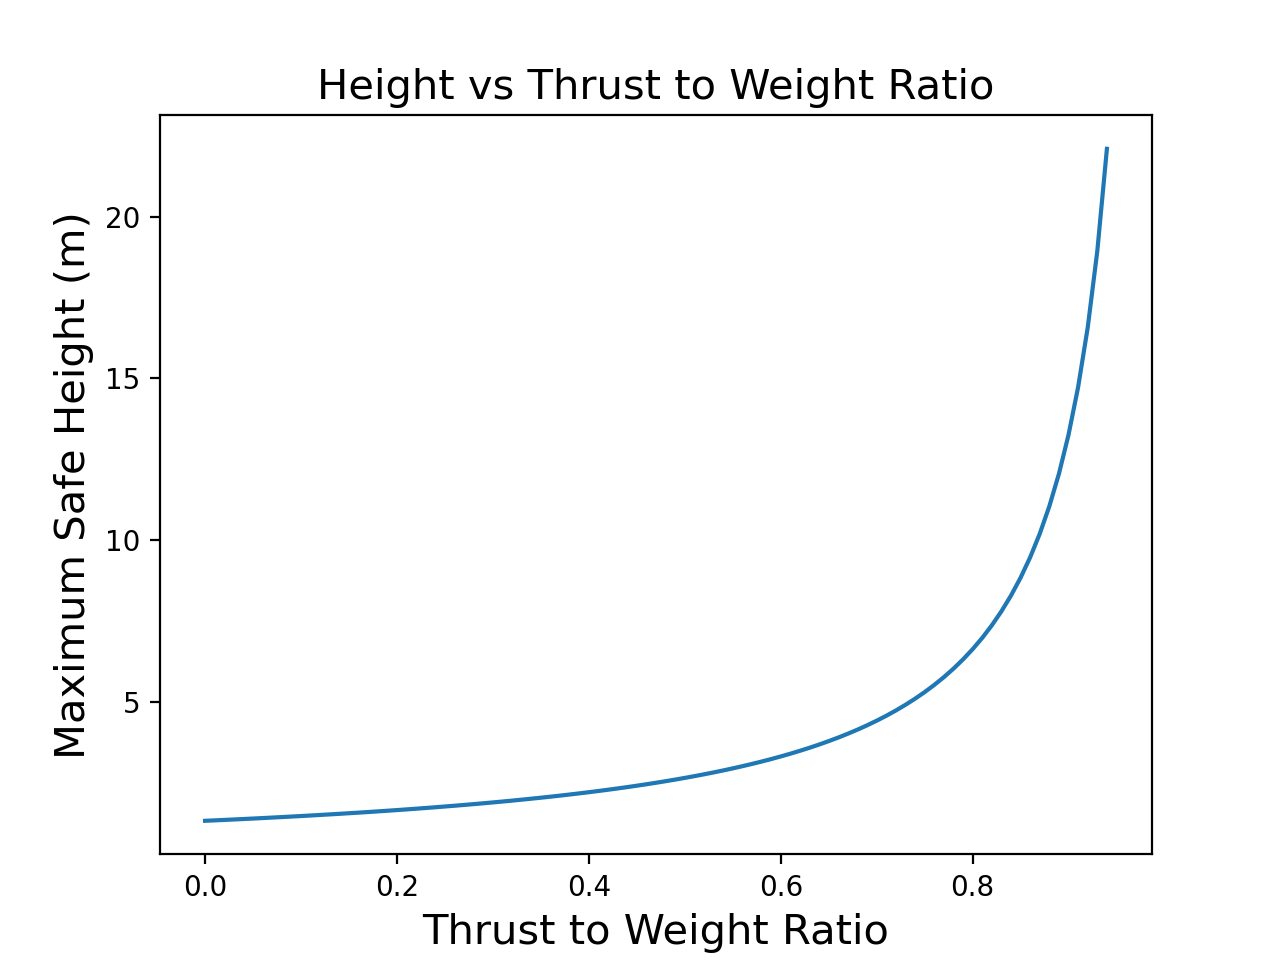

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

maxVS = 5.1    # Maxmimum safe vertical speed in m/s given gear strength rating

thrustToWeight = []
height = []

for a in np.arange(0, 0.95, 0.01):
    s = maxVS**2 / (2 * (1 - a) * 9.81)
    thrustToWeight.append(a)
    height.append(s)
    
plt.figure()
plt.plot(thrustToWeight, height)
plt.xlabel("Thrust to Weight Ratio", fontsize=15)
plt.ylabel("Maximum Safe Height (m)", fontsize=15)
plt.title("Height vs Thrust to Weight Ratio", fontsize=15)
plt.show()

## On a Wing...

On the failure of the one engine, we assume there is enough pitch authority to pitch the nose down and to then target and 
hold an alpha command equal to $C_l$ max. The assumption is that all the thrust available on the working engine is directed to the lift fans. Could consider recovery procedures that split and vary the thrust between the lift fans and the engine aligned with the aircraft's x-axis if it improves the recovery procedure.

### Aircraft Config

The wing area has been configured in conjunction with the aero data to achieve level flight at 100KIAS at an AoA of 5 degrees.

In [2]:
from math import radians, degrees, atan2, sin, cos, sqrt

# Nature
rho = 1.229            # kg/m^3, not varying based on altitude
g = 9.81               # m/s^2

# Aircraft
wing_area = 55         # m^2
aircraft_mass = 5000   # kg
max_thrust = 1.2 * aircraft_mass * g  # N
max_pitch_rate = 10        # deg/s
alpha_command_target = 13  # deg, based on Cl_max

engine_out_thrust = 0.5 * max_thrust  # N

### Aero Data

Since we don't have aero data, in particular to a maximum AoA of 90 degrees, I'm using the following data from [Aerodynamic characteristics of seven symmetrical airfoil sections through 180-degree angle of attack for use in aerodynamic analysis of vertical axis wind turbines](https://www.osti.gov/servlets/purl/6548367) as a place-holder for now. 

In addition to the data covering 180 degrees of alpha it also includes data for various Reynolds numbers. Currently using the fairly low Reynolds number of 2 million.

In [3]:
# Aero Data
alphas = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90 ]
Cls = [ 0, 0.11, 0.22, 0.33, 0.44, 0.55, 0.66, 0.77, 0.88, 0.99, 1.0727, 1.1539, 1.2072, 1.2169, 1.1614, 1.0478, 0.9221, 0.7826, 0.7163, 0.7091, 0.7269, 0.7595, 0.7981, 0.8429, 0.8882, 0.9352, 0.9842, 1.0355, 0.9150, 1.0200, 1.0750, 1.0850, 1.0400, 0.9650, 0.8750, 0.7650, 0.6500, 0.5150, 0.3700, 0.2200, 0.0700 ]
Cds = [ 0.0064, 0.0064, 0.0066, 0.0069, 0.0073, 0.0081, 0.0090, 0.0097, 0.0105, 0.0113, 0.0128, 0.0140, 0.0155, 0.0172, 0.0191, 0.0213, 0.0237, 0.1380, 0.2520, 0.2740, 0.2970, 0.3200, 0.3440, 0.3690, 0.3940, 0.4200, 0.4460, 0.4730, 0.5700, 0.7450, 0.9200, 1.0750, 1.2150, 1.3450, 1.4700, 1.5750, 1.6650, 1.7350, 1.7800, 1.8, 1.8 ] 

<IPython.core.display.Javascript object>


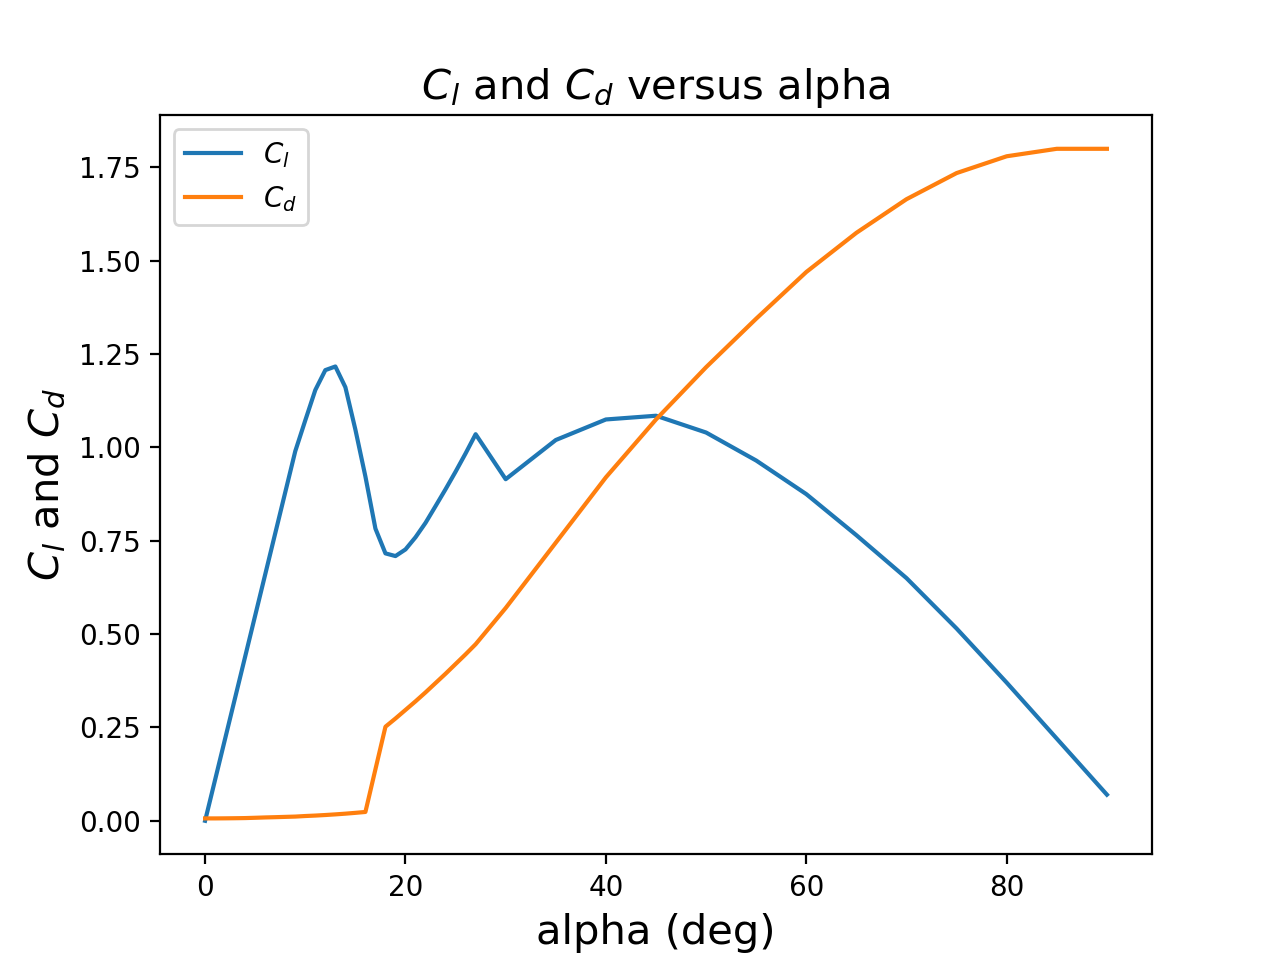

In [4]:
# Plot the aero data
plt.figure()

plt.plot(alphas, Cls, label="$C_l$")
plt.plot(alphas, Cds, label="$C_d$")

plt.xlabel("alpha (deg)", fontsize=15)
plt.ylabel("$C_l$ and $C_d$", fontsize=15)
plt.title("$C_l$ and $C_d$ versus alpha", fontsize=15)
plt.legend()
plt.show()

### 3-DOF Simulation Implementation

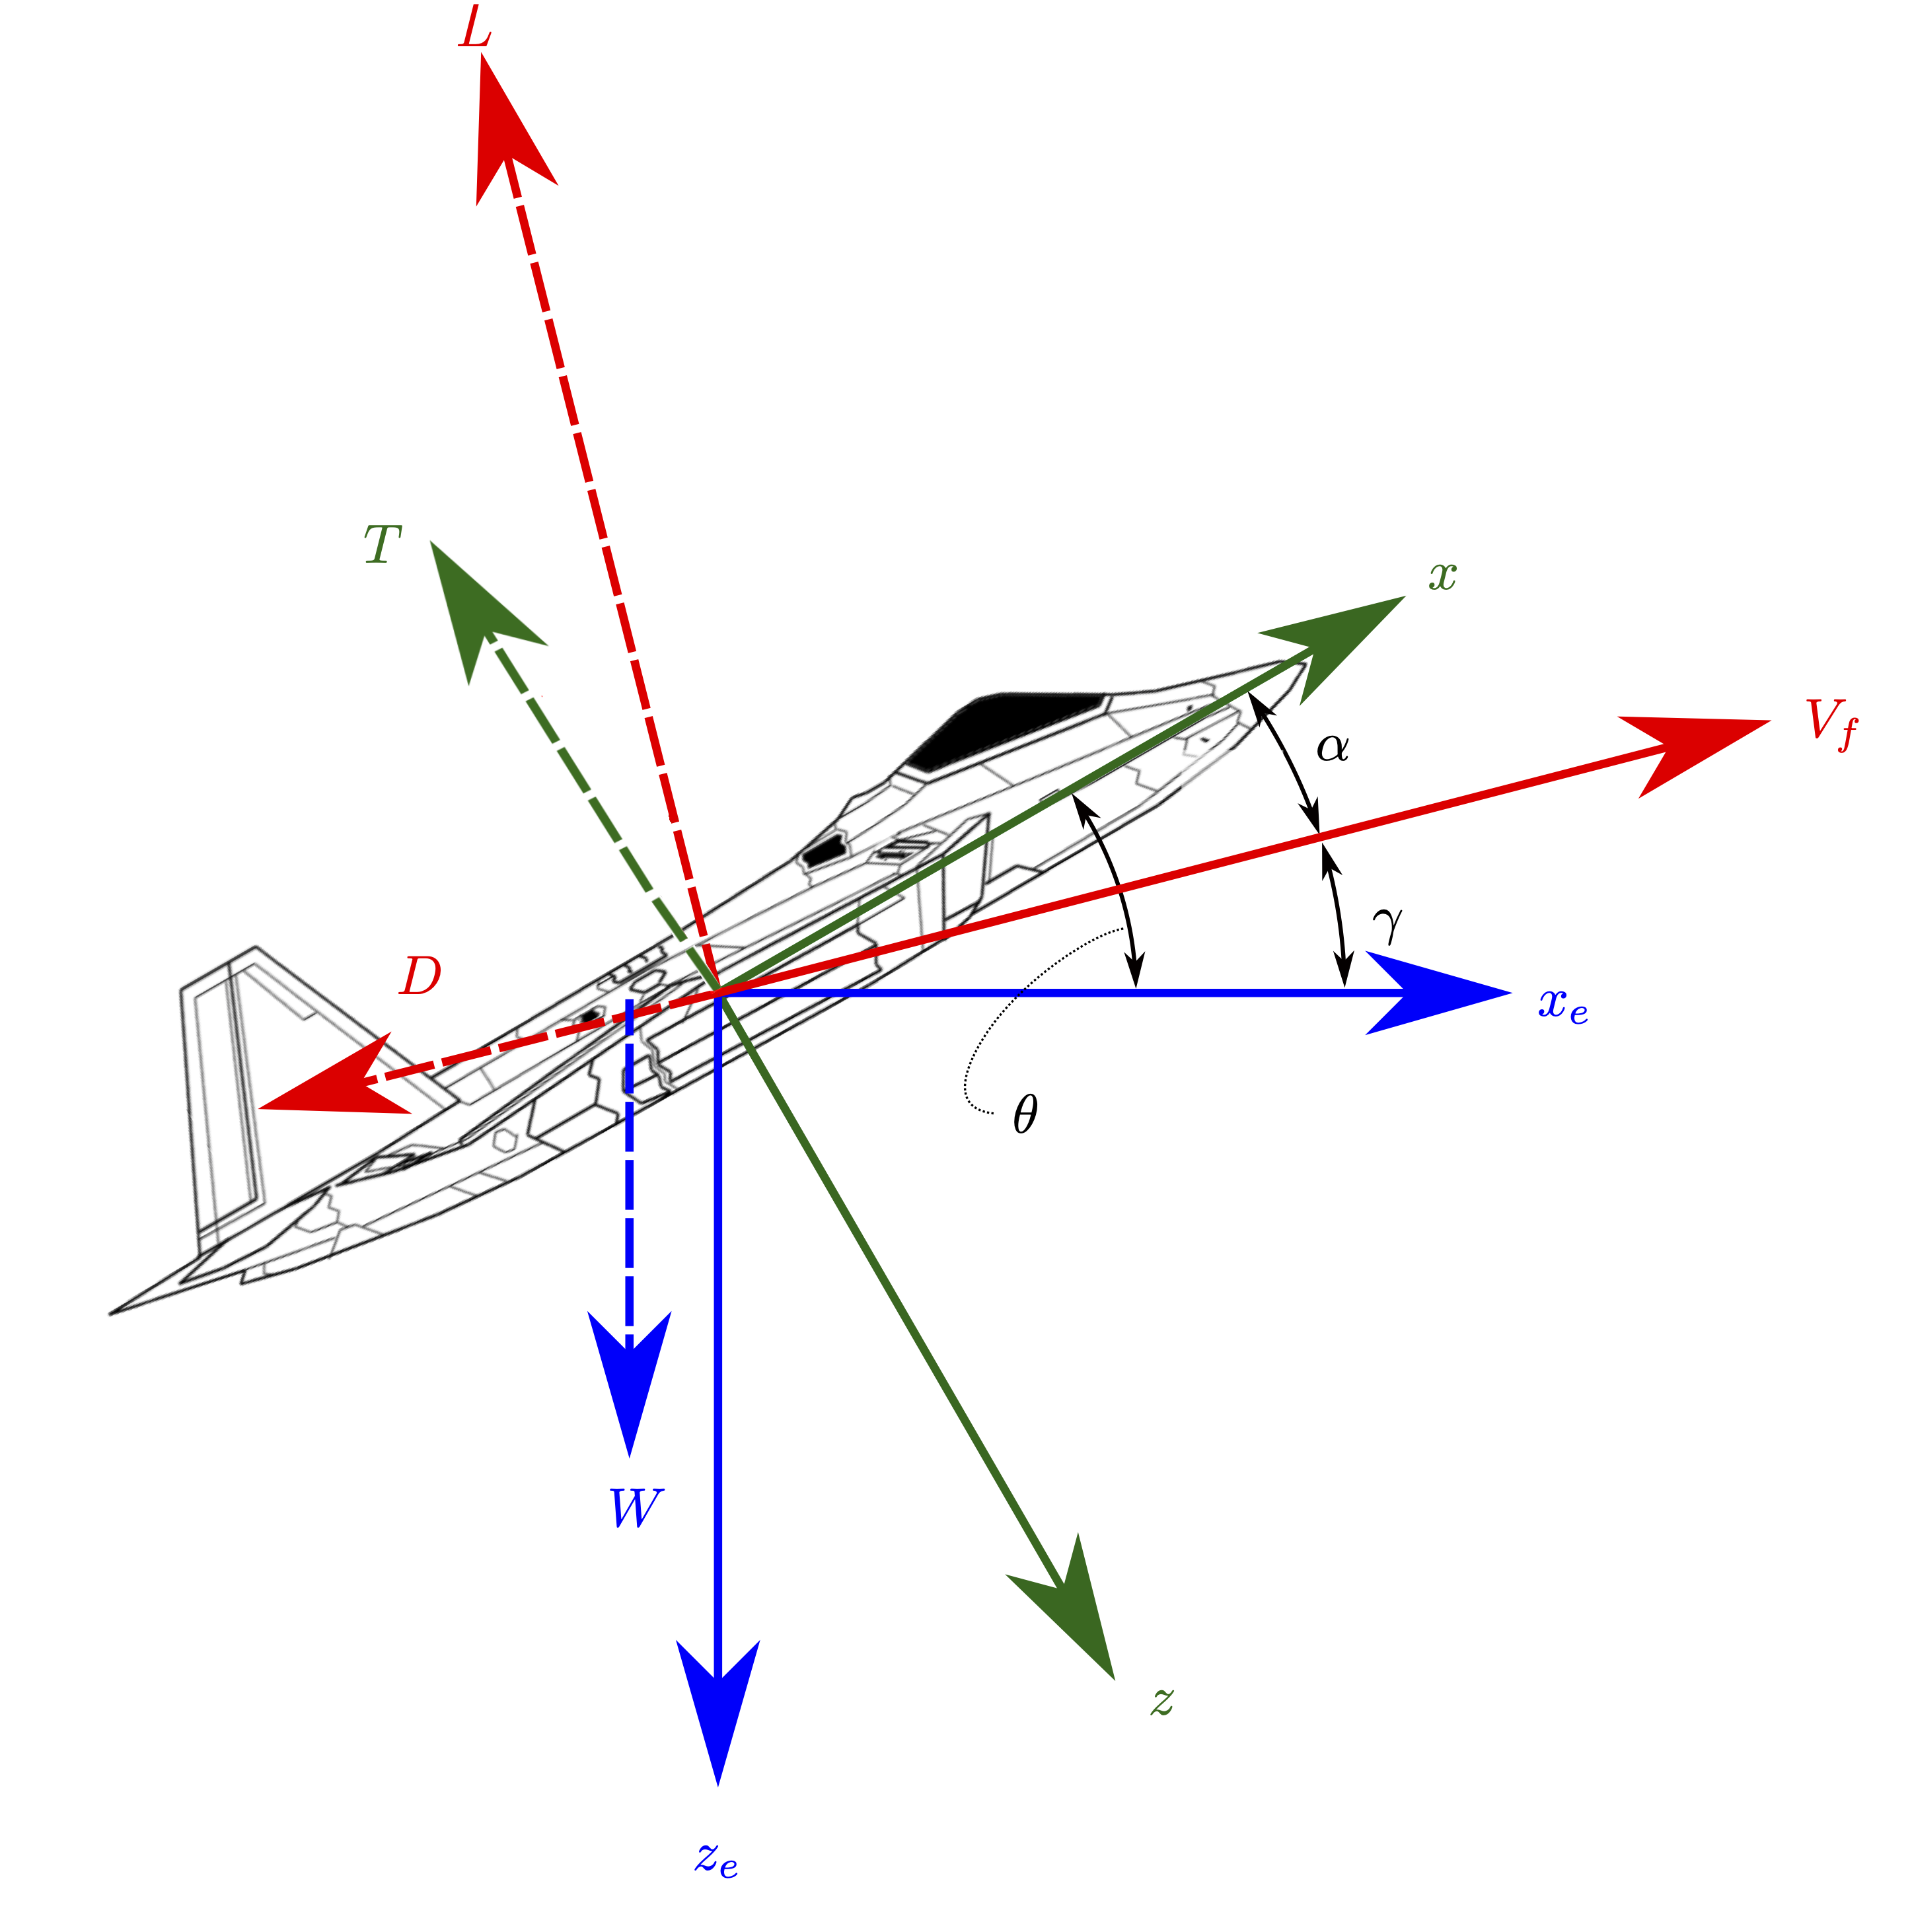

In [5]:
def calc_gamma(vx, vy):
    if vx == 0 and vy == 0:
        return 0
    if vx == 0:
        if vy > 0:
            return 90
        else:
            return -90
    return degrees(atan2(vy, vx))

In [6]:
def calc_alpha(theta, gamma):
    return theta - gamma

In [7]:
def thrust_force_from_body_to_inertial(thrust, theta):
    thrust_x = -thrust * sin(radians(theta))
    thrust_y =  thrust * cos(radians(theta))
    return thrust_x, thrust_y

In [8]:
def lift_drag_force_from_wind_to_inertial(lift, drag, gamma):
    Lx = lift * cos(radians(gamma + 90))
    Ly = lift * sin(radians(gamma + 90))
    Dx = drag * cos(radians(gamma + 180))
    Dy = drag * sin(radians(gamma + 180))
    return (Lx, Ly, Dx, Dy)

In [9]:
def lift_force(alpha, v):
    Cl = np.interp(alpha, alphas, Cls)
    return 0.5 * rho * Cl * wing_area * v**2

In [10]:
def drag_force(alpha, v):
    Cd = np.interp(alpha, alphas, Cds)
    return 0.5 * rho * Cd * wing_area * v**2

#### Simulation Loop

In [11]:
dt = 0.01  # 100Hz

weight = aircraft_mass * g

# State and initial conditions
starting_altitude = 300         # m
x, y = 0, starting_altitude     # m
vx, vy = 0, 0                   # m/s
theta = 0                       # degrees
gamma, alpha = 0, 0             # degrees

reaction_time = 0               # s

time_history = [0]
position_x_history = [x]
position_y_history = [y]
vy_history = [0]
alpha_history = [alpha]
gamma_history = [gamma]
theta_history = [theta]
airspeed_history = [0]
delta_altitude_history = [0]
lift_y_history = [0]
thrust_y_history = [engine_out_thrust]

time = 0

while(True):
    # Calculate current airspeed
    v = sqrt(vx**2 + vy**2)
    
    # Calculate forces
    lift = lift_force(alpha, v)
    drag = drag_force(alpha, v)
    
    # Convert forces into inertial x and y components
    Lx, Ly, Dx, Dy = lift_drag_force_from_wind_to_inertial(lift, drag, gamma)
    engine_x, engine_y = thrust_force_from_body_to_inertial(engine_out_thrust, theta)
    
    # Sum forces
    F_x = Lx + Dx + engine_x
    F_y = Ly + Dy + engine_y - weight
    
    # Resultant accelerations
    a_x = F_x / aircraft_mass
    a_y = F_y / aircraft_mass
    
    # Integrations for velocity and position
    d_vx = a_x * dt
    d_vy = a_y * dt
    x += (vx + 0.5 * d_vx) * dt
    y += (vy + 0.5 * d_vy) * dt
    vx += d_vx
    vy += d_vy
    
    # Calculate gamma, alpha
    gamma = calc_gamma(vx, vy)
    alpha = calc_alpha(theta, gamma)
    
    # FCS logic - simple alpha command with alpha target matching Cl_max
    if time >= reaction_time:
        alpha_error = alpha - alpha_command_target
        if abs(alpha_error) > 0.1:
            max_pitch_delta = max_pitch_rate * dt
            if alpha > alpha_command_target:
                theta -= min(max_pitch_delta, abs(alpha_error))
            else:
                theta += min(max_pitch_delta, abs(alpha_error))
    
    # Time marches on
    time += dt
    
    # History recording
    time_history.append(time)
    position_x_history.append(x)
    position_y_history.append(y)
    vy_history.append(vy)
    alpha_history.append(alpha)
    gamma_history.append(gamma)
    theta_history.append(theta)
    airspeed_history.append(sqrt(vx**2 + vy**2) * 1.944012)  # knots
    delta_altitude_history.append(starting_altitude - y)
    lift_y_history.append(Ly)
    thrust_y_history.append(engine_y)    
    
    # Have we recovered or crashed?
    if y < 0:
        print("Crashed... time: {time:.1f}s")
        break
    if gamma > 0:
        print(f"Recovered... time: {time:.1f}s  recovery altitude: {y:.1f}m   altitude lost: {starting_altitude - y:.1f}m")
        break
    

Recovered... time: 9.7s  recovery altitude: 193.7m   altitude lost: 106.3m


### Results

#### Profile View

Showing altitude loss versus horizontal range flown.

<IPython.core.display.Javascript object>


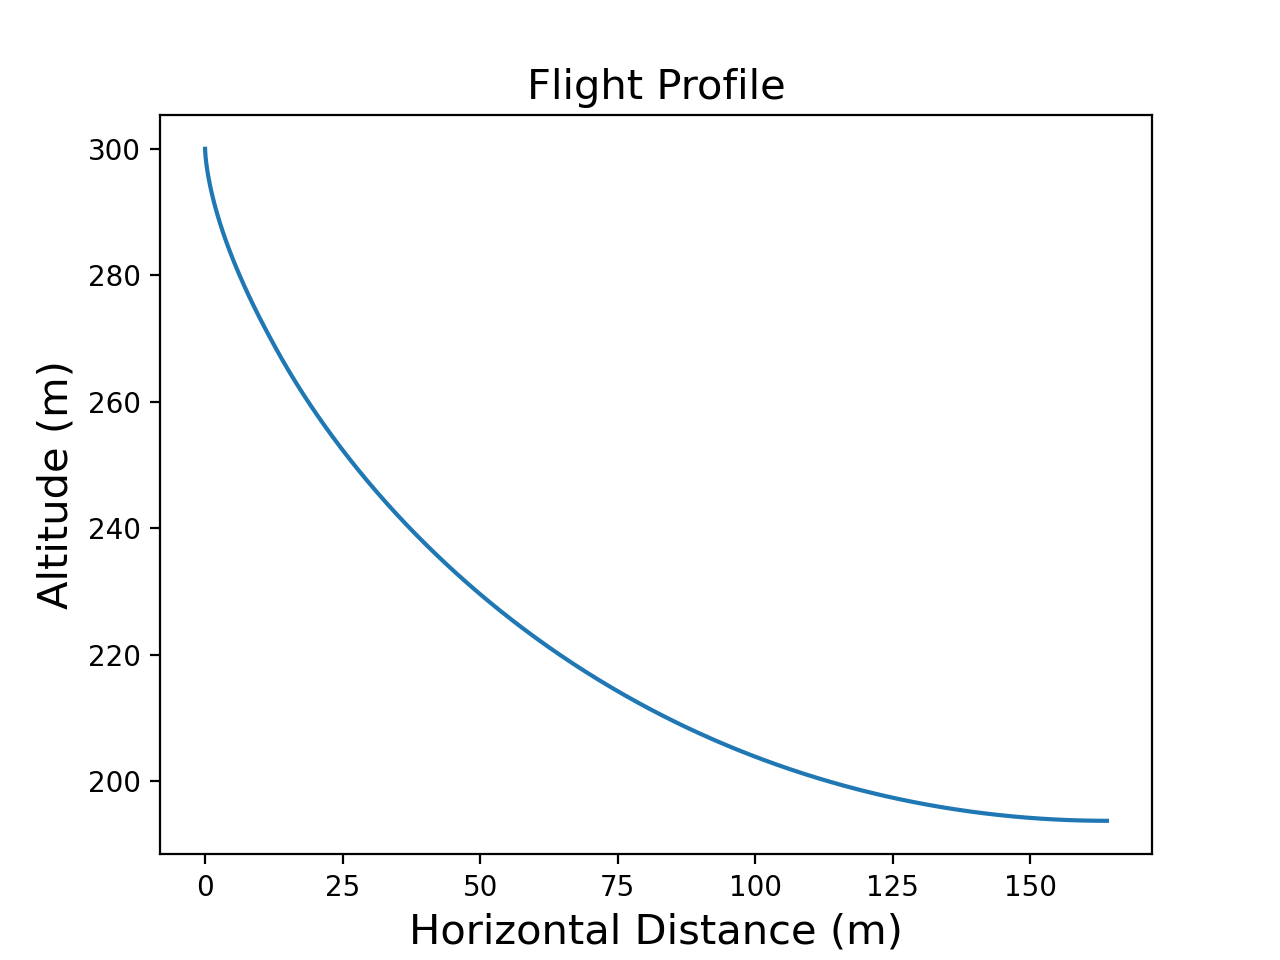

In [12]:
plt.figure()
plt.plot(position_x_history, position_y_history)
plt.xlabel("Horizontal Distance (m)", fontsize=15)
plt.ylabel("Altitude (m)", fontsize=15)
plt.title(r"Flight Profile", fontsize=15)
plt.show()

#### Angles

Showing the time history for all the angles. Max pitch angle of -42 degrees, ending with +12 degrees.

<IPython.core.display.Javascript object>


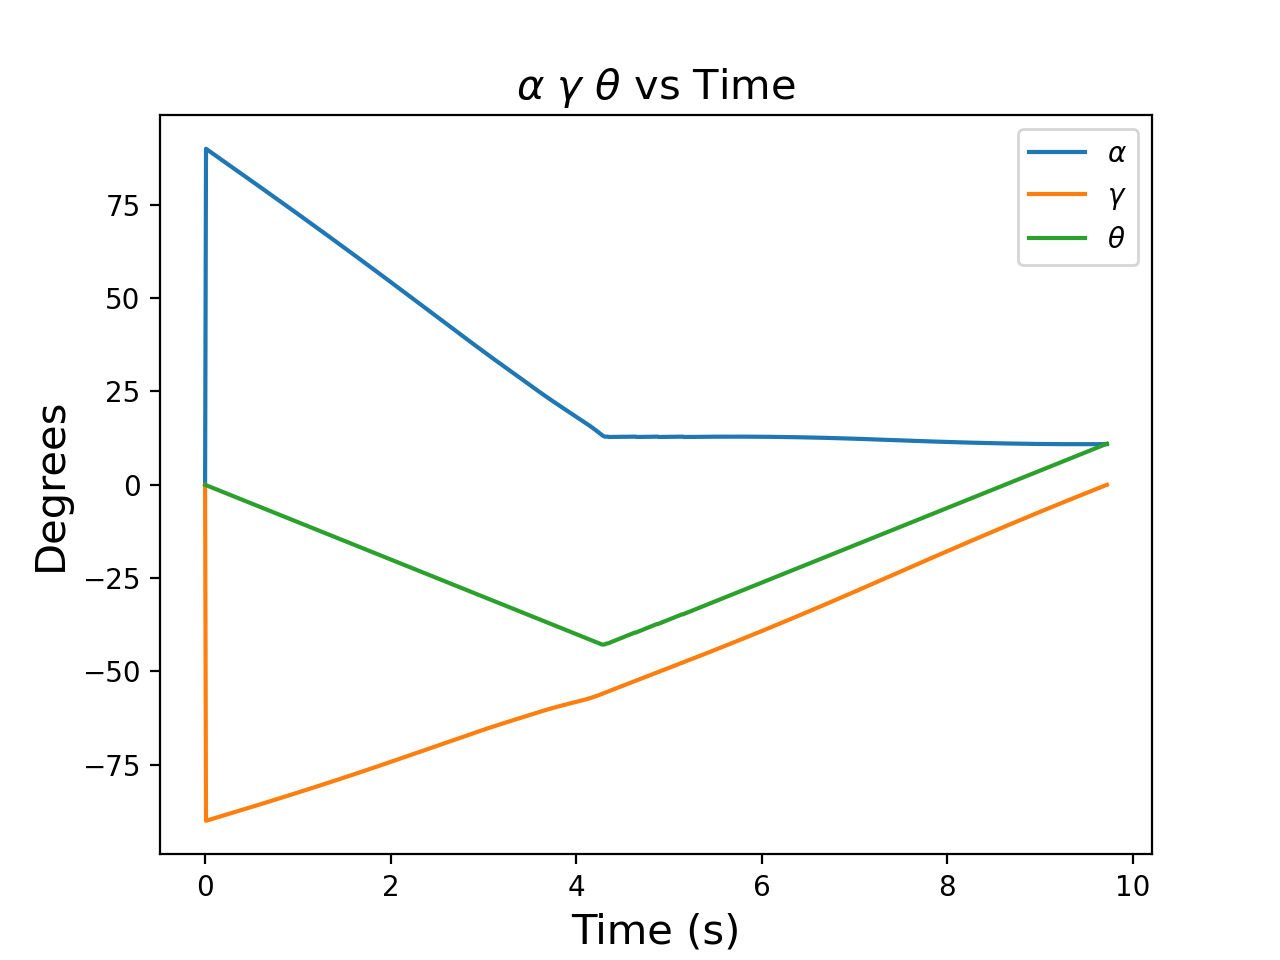

In [13]:
plt.figure()
plt.plot(time_history, alpha_history, label=r"$\alpha$")
plt.plot(time_history, gamma_history, label=r"$\gamma$")
plt.plot(time_history, theta_history, label=r"$\theta$")
plt.xlabel("Time (s)", fontsize=15)
plt.ylabel("Degrees", fontsize=15)
plt.title(r"$\alpha$ $\gamma$ $\theta$ vs Time", fontsize=15)
plt.legend()
plt.show()

#### Airspeed

<IPython.core.display.Javascript object>


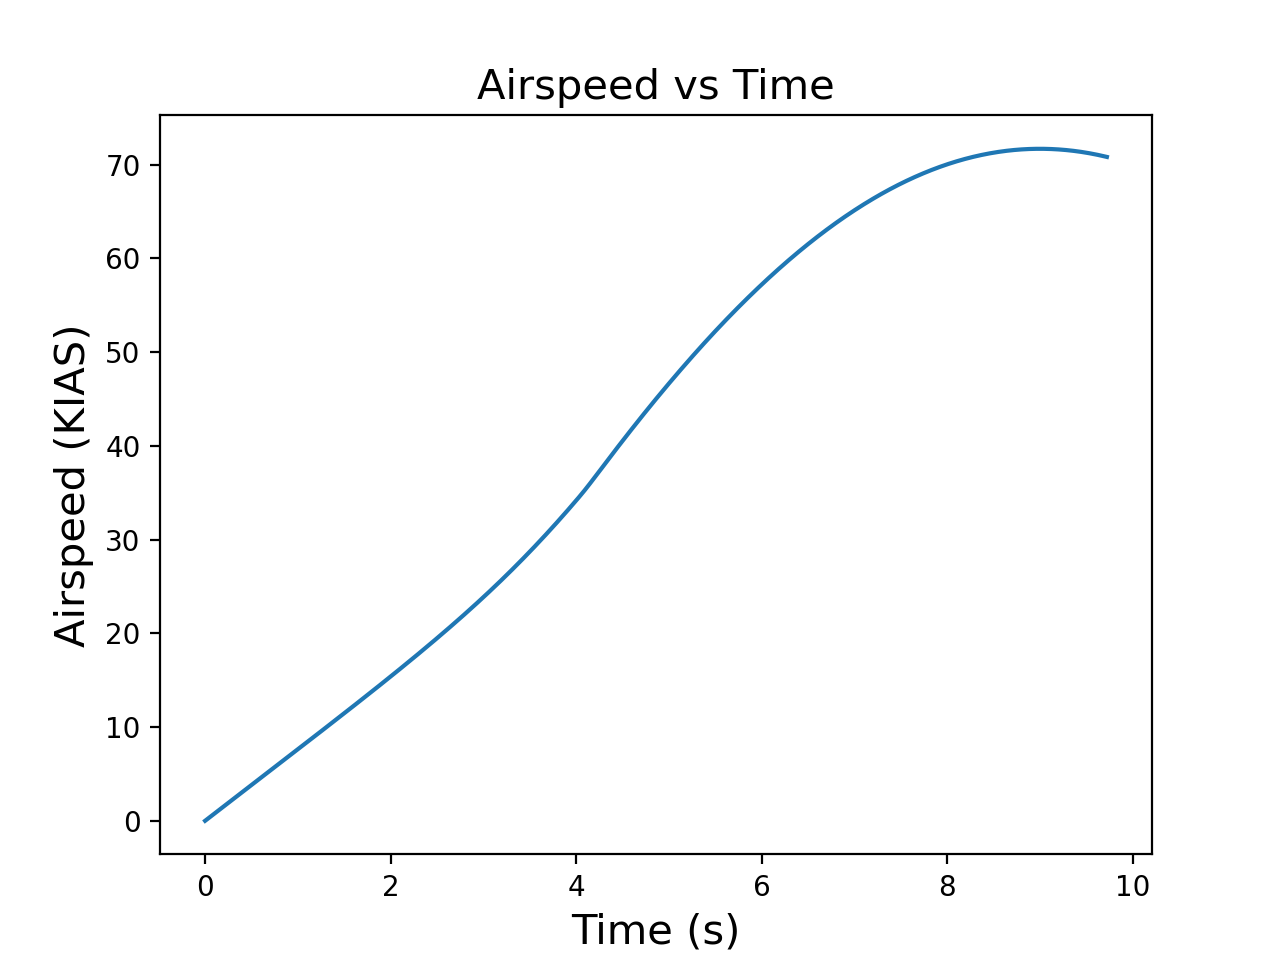

In [14]:
plt.figure()
plt.plot(time_history, airspeed_history)
plt.xlabel("Time (s)", fontsize=15)
plt.ylabel("Airspeed (KIAS)", fontsize=15)
plt.title("Airspeed vs Time", fontsize=15)
plt.show()

#### Vertical Speed

<IPython.core.display.Javascript object>


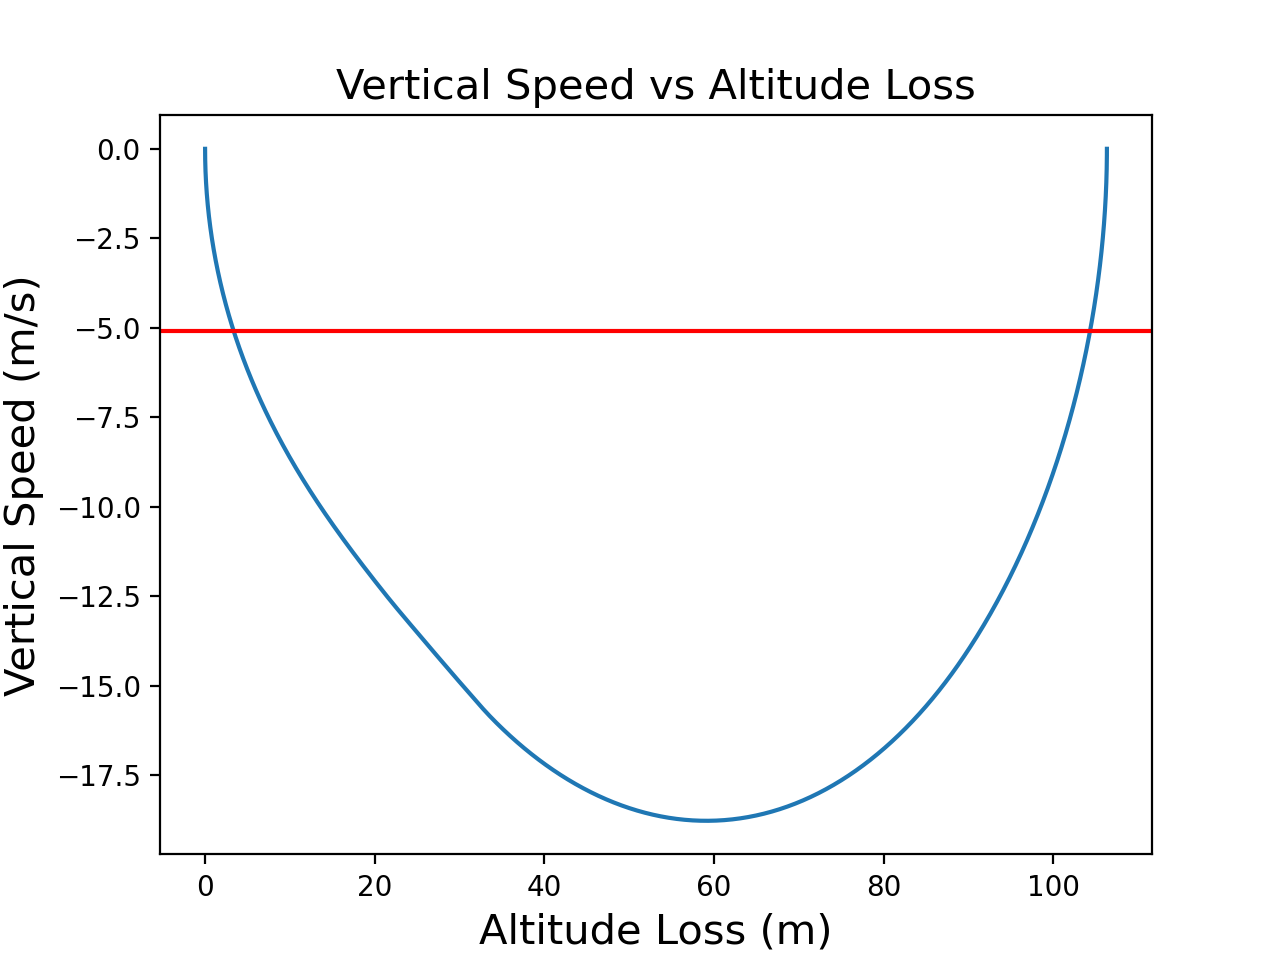

In [15]:
plt.figure()
plt.plot(delta_altitude_history, vy_history)
plt.axhline(y = -maxVS, color = 'r', linestyle = '-')
plt.xlabel("Altitude Loss (m)", fontsize=15)
plt.ylabel("Vertical Speed (m/s)", fontsize=15)
plt.title("Vertical Speed vs Altitude Loss", fontsize=15)
plt.show()

#### Aerodynamic Lift vs Lift Fan Lift

Lift in the inertial y axis.

<IPython.core.display.Javascript object>


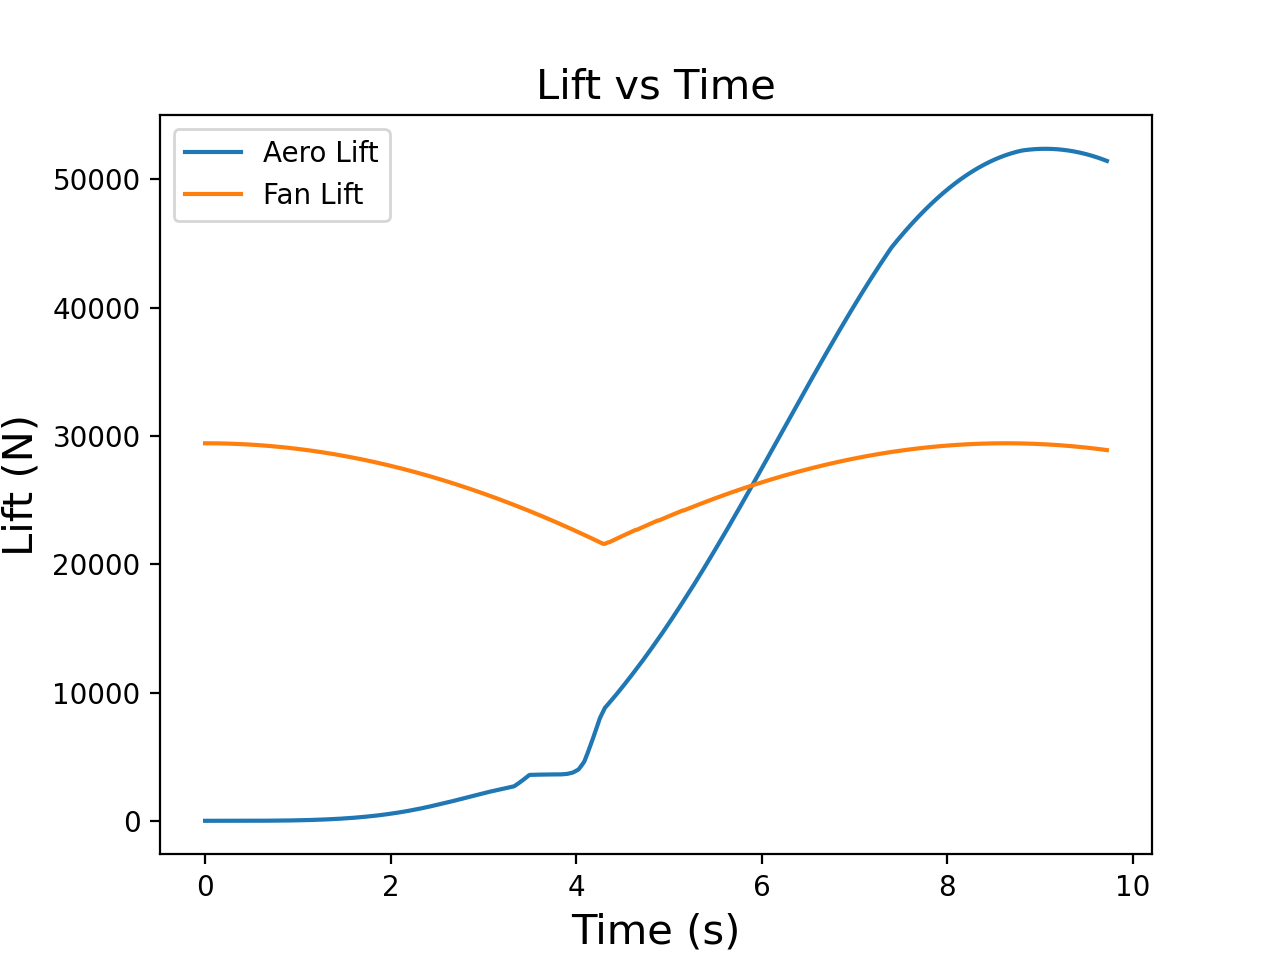

In [16]:
plt.figure()
plt.plot(time_history, lift_y_history, label="Aero Lift")
plt.plot(time_history, thrust_y_history, label="Fan Lift")
plt.xlabel("Time (s)", fontsize=15)
plt.ylabel("Lift (N)", fontsize=15)
plt.title("Lift vs Time", fontsize=15)
plt.legend()
plt.show()